# Import Library

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data 준비

## Data Load

In [42]:

# 데이터 불러오기
data = pd.read_csv("../data/comment_translation_predict_label.csv")  # 중복 제거된 데이터 (ex: df.iloc[1200:, :])
train_df = pd.read_csv("../data/train.csv")  # 원본 데이터



In [43]:
data

,review_comment_message,review_comment_message_en,Product_Quality,Delivery,Price,Repurchase_Intention,etc
0,"Produto preto, reembalado na caixa de um branc...","Black product, repacked in a white box, lots o...",-1,0,0,0,0
1,FICAMOS ESPERANDO UMA ENCOMENDA PAGA QUE NUNCA...,WE'RE STILL EXPERIENCED WITH A RECOMMENDATION ...,0,0,0,0,-1
2,Otimo muito bom,Very good.,0,0,0,0,1
3,Entrega antes do prazo. Produto muito bom e bo...,"It arrives by the deadline. Very good product,...",1,1,0,0,0
4,excelente.,excellent.,0,0,0,0,1
...,...,...,...,...,...,...,...
35170,"Muito obrigada , uma atenção nota 10, profissi...","Thank you very much, a note 10 for your attent...",1,0,0,1,0
35171,Produto entregue dentro do prazo . Gostei muito.,I got it delivered on time. I appreciate it.,0,1,0,0,0
35172,Essa capa não encaixa direito. Não consigo tro...,That layer doesn't fit right. I can't change it.,-1,0,0,0,0
35173,"Mim deixou esperar muito tempo, para depois vi...",So he waited a long time for me to let him kno...,0,-1,0,0,0


In [44]:
# 'review_comment_message'를 기준으로 데이터 병합
df = pd.merge(train_df, data, on='review_comment_message', how='left')
# # 불필요한 'review_comment_message' 컬럼 삭제
# df = df.drop(columns=['review_comment_message'])

# 결과 확인
print(df.head())

                           order_id                       customer_id  \
0  d455a8cb295653b55abda06d434ab492  944b72539d7e1f7f7fc6e46639ef1fe3   
1  7f39ba4c9052be115350065d07583cac  d7fc82cbeafea77bd0a8fbbf6296e387   
2  9dc8d1a6f16f1b89874c29c9d8d30447  d9442164acf4b03109425633efaa0cfc   
3  0f548bd29148ebc519d6495e37a284e1  015faf9ec36eccd957c0f2782aab09a4   
4  0f548bd29148ebc519d6495e37a284e1  015faf9ec36eccd957c0f2782aab09a4   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-09-26 22:17:05  2017-09-27 22:24:16   
1    delivered      2017-10-18 08:16:34  2017-10-18 23:56:20   
2    delivered      2017-10-12 13:33:22  2017-10-12 13:49:22   
3    delivered      2017-09-03 08:06:30  2017-09-03 08:25:50   
4    delivered      2017-09-03 08:06:30  2017-09-03 08:25:50   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-09-29 15:53:03           2017-10-07 16:12:47   
1          2017-10-20 14:29:01           2017-10

In [45]:
pt = list(pd.DataFrame(df['review_comment_message']).dropna().index)

In [46]:
len(pt)

48905

In [47]:
en = list(pd.DataFrame(df['review_comment_message_en']).dropna().index)

In [48]:
len(en)

48905

In [49]:
pt_not_in_en = list(set(pt) - set(en))

en_not_in_pt = list(set(en) - set(pt))

print("pt 리스트에 포함되지 않은 en의 원소:", pt_not_in_en)
print("en 리스트에 포함되지 않은 pt의 원소:", en_not_in_pt)

pt 리스트에 포함되지 않은 en의 원소: []
en 리스트에 포함되지 않은 pt의 원소: []


## 데이터 전처리
- 별점 O, 코멘트 X: 코멘트 length = 0으로 처리
- 별점 X, 코멘트 X: 해당 항목은 분석에서 제외 (drop)
- 별점을 준 고객은 리뷰를 남길 환경이 갖춰진 것으로 보고, 코멘트를 작성하지 않은 경우로 판단

In [50]:
df = df[df['review_score'].notnull() | df['review_comment_message_en'].notnull()]

In [51]:
len(df)

115610

In [52]:
df['review_comment_message_en'].isnull().sum()

66705

In [53]:
df['review_length'] = df['review_comment_message_en'].apply(lambda x: len(x) if pd.notnull(x) and x != "" else 0)


# 0. 리뷰 평균 길이

In [54]:
review_avg_length = df['review_length'].mean()

# 결과 출력
print(f"리뷰의 평균 길이: {review_avg_length:.2f}")


리뷰의 평균 길이: 31.24


In [55]:
median_review_length = df[df['review_length'] != 0]['review_length'].median()

# 결과 출력
print(f"리뷰의 중앙값 길이: {median_review_length:.2f}")

리뷰의 중앙값 길이: 56.00


# 1. 상위 리뷰 길이 기준

In [56]:
# 상위 10%부터 50%까지 리뷰 길이 기준으로 구간을 설정하고 각 구간별 평균 계산
percentiles = [95, 90, 85, 80, 75, 70, 65, 60, 55, 50]  # 상위 10%부터 50%까지
length_percentile_averages = {}

for p in percentiles:
    threshold = df['review_length'].quantile(p / 100)  # 특정 백분위수에 해당하는 길이
    avg_length = df[df['review_length'] >= threshold]['review_length'].mean()
    length_percentile_averages[f"Top {100 - p}%"] = avg_length

# 결과 출력
print("상위 리뷰 길이 기준에 따른 평균 리뷰 길이:")
for percentile, avg_length in length_percentile_averages.items():
    print(f"{percentile} 평균 리뷰 길이: {avg_length:.2f}")


상위 리뷰 길이 기준에 따른 평균 리뷰 길이:
Top 5% 평균 리뷰 길이: 195.55
Top 10% 평균 리뷰 길이: 161.90
Top 15% 평균 리뷰 길이: 137.79
Top 20% 평균 리뷰 길이: 119.97
Top 25% 평균 리뷰 길이: 106.75
Top 30% 평균 리뷰 길이: 94.86
Top 35% 평균 리뷰 길이: 86.06
Top 40% 평균 리뷰 길이: 77.10
Top 45% 평균 리뷰 길이: 31.24
Top 50% 평균 리뷰 길이: 31.24


# 2. 부정 리뷰 길이 기준

In [57]:
# 별점 1에 해당하는 부정적 리뷰의 평균 길이 계산
negative_review_avg_length1 = df[df['review_score'] == 1]['review_length'].mean()

# 결과 출력
print(f"별점 1 부정 리뷰의 평균 길이: {negative_review_avg_length1:.2f}")
# 별점 1, 2에 해당하는 부정적 리뷰의 평균 길이 계산
negative_review_avg_length2 = df[df['review_score'].isin([1,2])]['review_length'].mean()

# 결과 출력
print(f"별점 1, 2 부정 리뷰의 평균 길이: {negative_review_avg_length2:.2f}")


별점 1 부정 리뷰의 평균 길이: 82.08
별점 1, 2 부정 리뷰의 평균 길이: 80.03


# 3. 별점에 따른 리뷰 비교

In [58]:
# 별점 1인 리뷰의 평균 길이 계산
star_group1 = [1]
group1_avg_length = df[df['review_score'].isin(star_group1)]['review_length'].mean()

# 별점 1, 2인 리뷰의 평균 길이 계산
star_group2 = [1, 2]
group2_avg_length = df[df['review_score'].isin(star_group2)]['review_length'].mean()

# 결과 출력
print(f"별점 1, 5 리뷰의 평균 길이: {group1_avg_length:.2f}")
print(f"별점 1, 2, 4, 5 리뷰의 평균 길이: {group2_avg_length:.2f}")


별점 1, 5 리뷰의 평균 길이: 82.08
별점 1, 2, 4, 5 리뷰의 평균 길이: 80.03


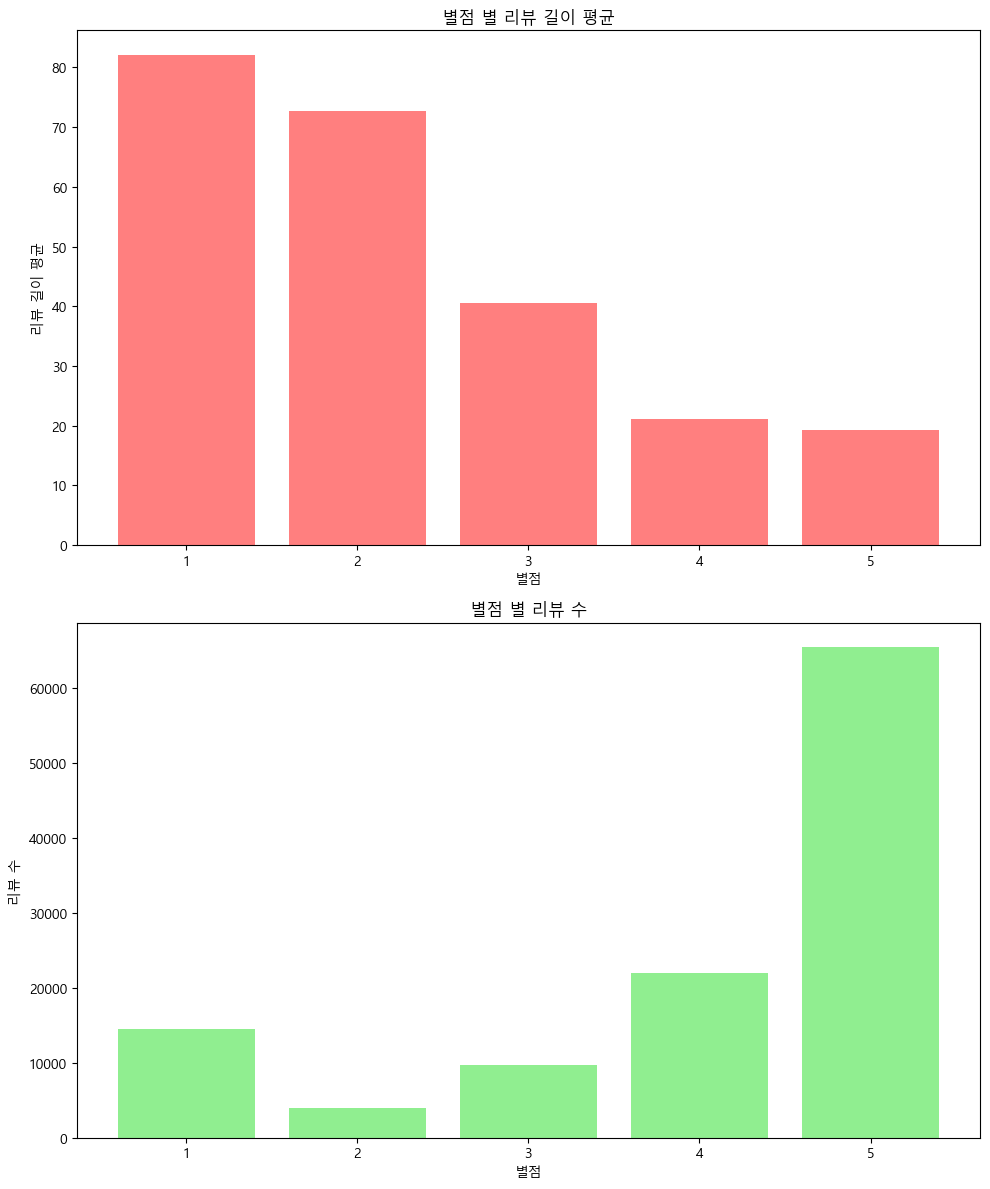

별점 별 리뷰 길이 평균:
review_score
1.0    82.081776
2.0    72.618254
3.0    40.566770
4.0    21.159810
5.0    19.369856
Name: review_length, dtype: float64

별점 별 리뷰 수:
review_score
1.0    14552
2.0     4021
3.0     9720
4.0    21951
5.0    65366
Name: count, dtype: int64


In [59]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
# 별점 별 리뷰 길이 평균 계산
average_length_by_star = df.groupby('review_score')['review_length'].mean()

# 별점 별 리뷰 수 계산
count_by_star = df['review_score'].value_counts().sort_index()

# 그래프 설정
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# 별점 별 리뷰 길이 평균 그래프
ax1.bar(average_length_by_star.index, average_length_by_star.values, color='red', alpha=0.5)
ax1.set_title("별점 별 리뷰 길이 평균")
ax1.set_xlabel("별점")
ax1.set_ylabel("리뷰 길이 평균")

# 별점 별 리뷰 수 그래프
ax2.bar(count_by_star.index, count_by_star.values, color='lightgreen')
ax2.set_title("별점 별 리뷰 수")
ax2.set_xlabel("별점")
ax2.set_ylabel("리뷰 수")

# 그래프 표시
plt.tight_layout()
plt.show()
# 결과 출력
print("별점 별 리뷰 길이 평균:")
print(average_length_by_star)

print("\n별점 별 리뷰 수:")
print(count_by_star)

# 4. 신뢰도 평가


## 각 항목에 대한 점수화

In [60]:
len_threthod = 100

In [61]:
df['length_score'] = df['review_length'].apply(lambda x: 1 if x >= len_threthod else 0)
df['quality_score'] = df['Product_Quality'].apply(lambda x: 1 if x != 0 else 0)
df['delivery_score'] = df['Delivery'].apply(lambda x: 1 if x != 0 else 0)

In [62]:
# 종합 신뢰도 점수 계산
df['trust_score'] = df['length_score'] + df['quality_score'] + df['delivery_score']


## 신뢰도 수준 평가

In [63]:

def evaluate_trust_level(score):
    if score == 3:
        return 'High'
    elif score == 2:
        return 'Mid'
    elif score == 1:
        return 'Low'
    else:
        return 'Very Low'


In [64]:
df['trust_level'] = df['trust_score'].apply(evaluate_trust_level)

In [65]:
# 결과 출력
print("리뷰별 신뢰도 평가 결과:")
print(df[['review_comment_message_en', 'length_score', 'quality_score', 'delivery_score', 'trust_score', 'trust_level']])

리뷰별 신뢰도 평가 결과:
                                review_comment_message_en  length_score  \
0                                                     NaN             0   
1       Black product, repacked in a white box, lots o...             1   
2                                                     NaN             0   
3                                                     NaN             0   
4                                                     NaN             0   
...                                                   ...           ...   
116569                                                NaN             0   
116570   That layer doesn't fit right. I can't change it.             0   
116571  So he waited a long time for me to let him kno...             0   
116572                                             Right.             0   
116573                                                NaN             0   

        quality_score  delivery_score  trust_score trust_level  
0                  

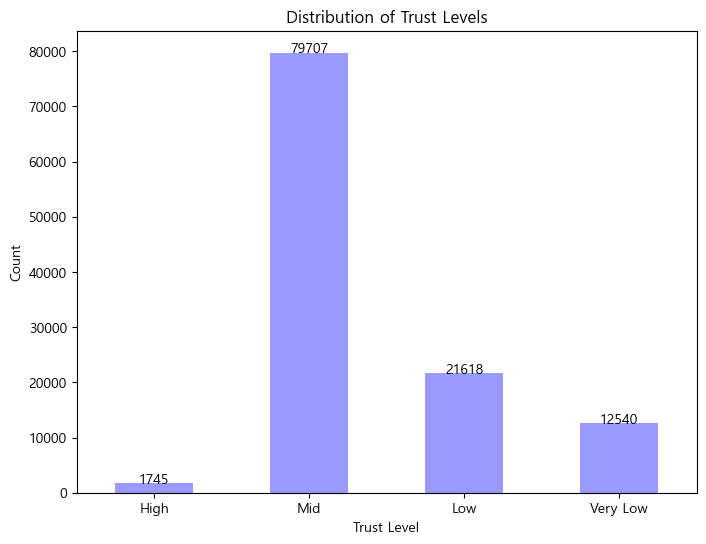

In [66]:
# 신뢰도 수준별 분포 계산
trust_level_counts = df['trust_level'].value_counts()
trust_level_counts = trust_level_counts.reindex(['High', 'Mid', 'Low', 'Very Low'])

# 분포 그래프 그리기
plt.figure(figsize=(8, 6))
trust_level_counts.plot(kind='bar', color='blue', alpha=0.4)
plt.title('Distribution of Trust Levels')
plt.xlabel('Trust Level')
plt.ylabel('Count')
plt.xticks(rotation=0)
for i, value in enumerate(trust_level_counts):
    plt.text(i, value + 1, f"{value:.0f}", ha='center')
plt.show()


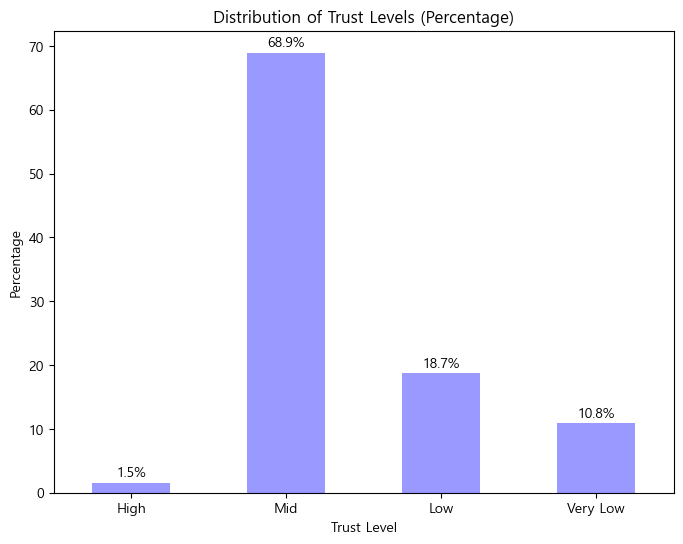

In [67]:
trust_level_counts = df['trust_level'].value_counts(normalize=True) * 100
trust_level_counts = trust_level_counts.reindex(['High', 'Mid', 'Low', 'Very Low'])
# 퍼센트 분포 그래프 그리기
plt.figure(figsize=(8, 6))
trust_level_counts.plot(kind='bar', color='blue', alpha=0.4)
plt.title('Distribution of Trust Levels (Percentage)')
plt.xlabel('Trust Level')
plt.ylabel('Percentage')
plt.xticks(rotation=0)

# 퍼센트 값 표시
for i, value in enumerate(trust_level_counts):
    plt.text(i, value + 1, f"{value:.1f}%", ha='center')

plt.show()

## MID 그룹 분포

In [68]:
# Mid 그룹 필터링
mid_group = df[df['trust_level'] == 'Mid']

# Mid 그룹의 조합 분포 계산
mid_combinations = mid_group.groupby(['length_score', 'quality_score', 'delivery_score']).size().reset_index(name='count')
mid_combinations = mid_combinations.sort_values(by='count', ascending=False)

print("Mid 그룹의 각 조합별 분포:")
print(mid_combinations)

Mid 그룹의 각 조합별 분포:
   length_score  quality_score  delivery_score  count
0             0              1               1  72605
2             1              1               0   4816
1             1              0               1   2286


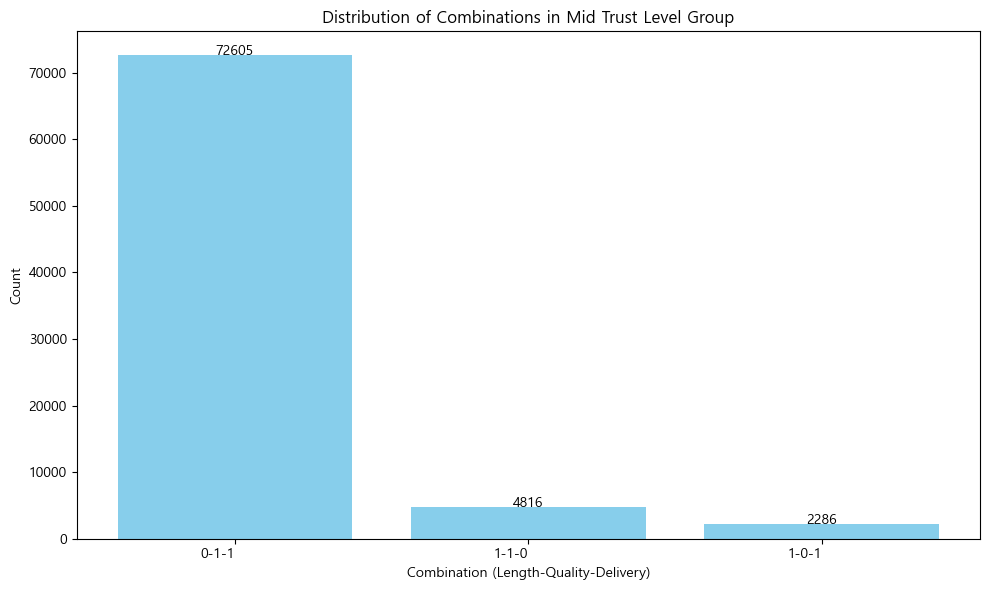

In [69]:
mid_combinations['combination'] = mid_combinations['length_score'].astype(str) + '-' + \
                                  mid_combinations['quality_score'].astype(str) + '-' + \
                                  mid_combinations['delivery_score'].astype(str)

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.bar(mid_combinations['combination'], mid_combinations['count'], color='skyblue')
plt.title('Distribution of Combinations in Mid Trust Level Group')
plt.xlabel('Combination (Length-Quality-Delivery)')
plt.ylabel('Count')

plt.xticks(rotation=0, ha='right')
for i, value in enumerate(mid_combinations['count']):
    plt.text(i, value + 1, f"{value:.0f}", ha='center')
plt.tight_layout()

plt.show()

In [70]:
# Mid 그룹 필터링
mid_group = df[df['trust_level'] == 'Mid']

# Mid 그룹의 각 조합별 리뷰 길이 평균 계산
mid_length_distribution = mid_group.groupby(['length_score', 'quality_score', 'delivery_score'])['review_length'].mean().reset_index()

print("Mid 그룹의 각 조합별 리뷰 길이 평균:")
print(mid_length_distribution)

Mid 그룹의 각 조합별 리뷰 길이 평균:
   length_score  quality_score  delivery_score  review_length
0             0              1               1       4.792686
1             1              0               1     155.979878
2             1              1               0     159.929817


## 현재 신뢰도 점수

In [71]:
round(df['trust_score'].mean()/3*100,2)

53.71

## 신뢰도 수준별 리뷰 길이 및 키워드 포함 여부 조합 분포

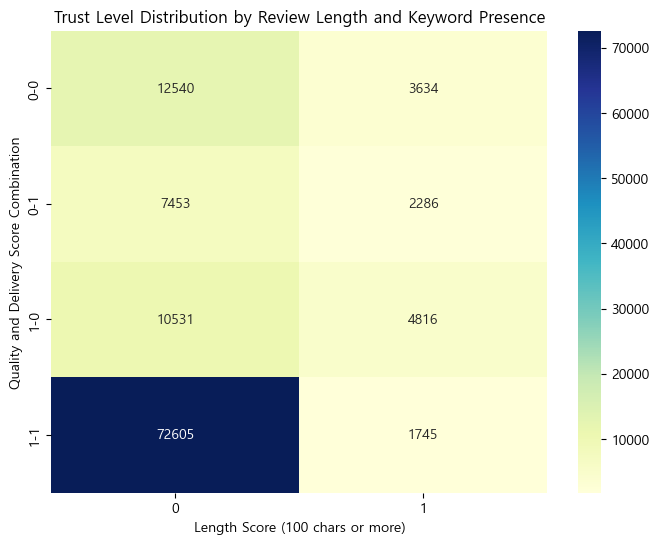

In [72]:
heatmap_data = df.groupby(['quality_score', 'delivery_score', 'length_score']).size().unstack(fill_value=0)

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt="d")
plt.title('Trust Level Distribution by Review Length and Keyword Presence')
plt.xlabel(f'Length Score ({len_threthod} chars or more)')
plt.ylabel('Quality and Delivery Score Combination')
plt.show()

- 품질과 배송 키워드가 모두 포함된 리뷰((1, 1))는 주로 짧은 리뷰로 작성됩니다. 이는 이 조합의 리뷰가 많지만, 자세한 설명 없이 간단한 피드백만 남기는 경향이 있을 수 있음.
- 품질 키워드만 포함된 리뷰((1, 0))가 상대적으로 길게 작성되는 경향이 있으며, 이는 품질에 대한 불만이나 칭찬이 있을 때 좀 더 상세하게 설명하려는 고객의 성향을 나타낼 수 있음.
- 배송 키워드만 포함된 리뷰((0, 1))는 품질 키워드만 포함된 경우보다 더 짧게 작성되는 경향이 있어, 배송에 대한 피드백은 간략히 작성되는 경우가 많음.

In [73]:
df.to_csv("../data/for_simulation.csv", index=False)

신뢰도 그룹별 소비 금액:
  Trust Level  Total Spending
0        High             180
1         Low             192
2         Mid             163
3    Very Low             192


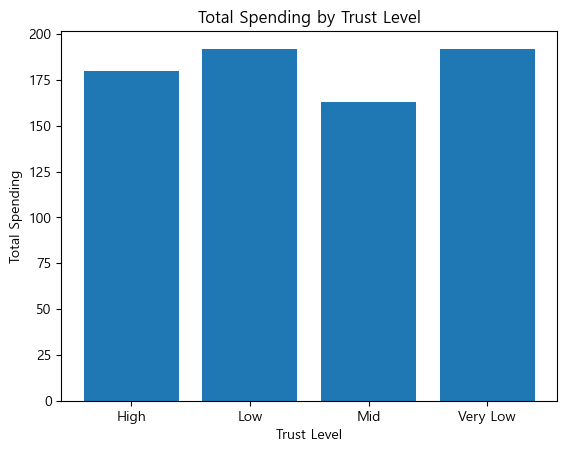

In [76]:
# 신뢰도 그룹별 소비 금액 계산
trust_level_spending = df.groupby('trust_level')['payment_value'].mean().reset_index()

# 소비 금액을 정수로 표현
trust_level_spending['payment_value'] = trust_level_spending['payment_value'].astype(int)

# 컬럼명 변경
trust_level_spending.columns = ['Trust Level', 'Total Spending']

# 결과 출력
print("신뢰도 그룹별 소비 금액:")
print(trust_level_spending)

# 그래프 시각화
import matplotlib.pyplot as plt

plt.bar(trust_level_spending['Trust Level'], trust_level_spending['Total Spending'])
plt.title("Total Spending by Trust Level")
plt.xlabel("Trust Level")
plt.ylabel("Total Spending")
plt.show()


High
1520 9


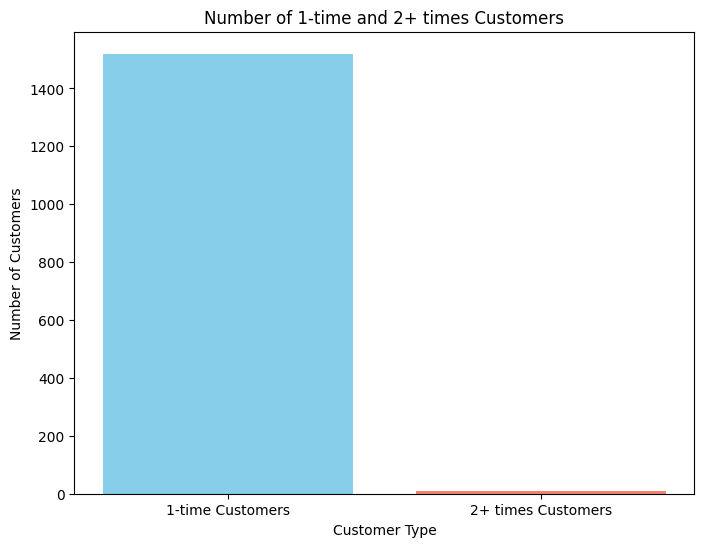

Mid
64391 1656


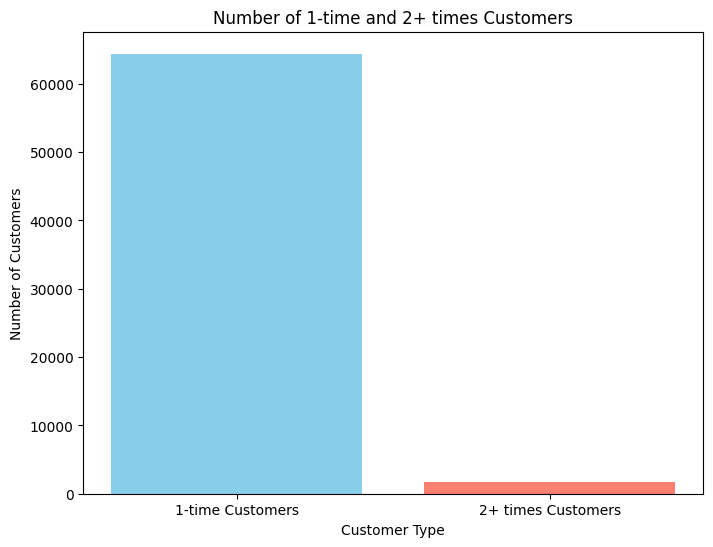

Low
16854 279


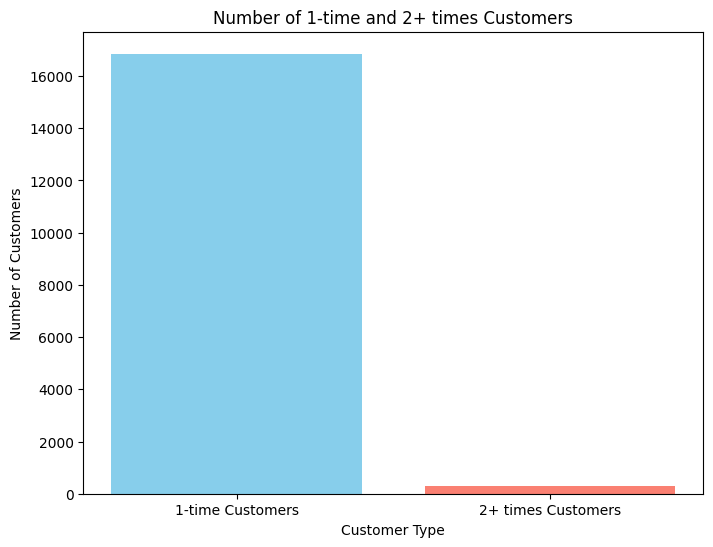

Very Low
9448 169


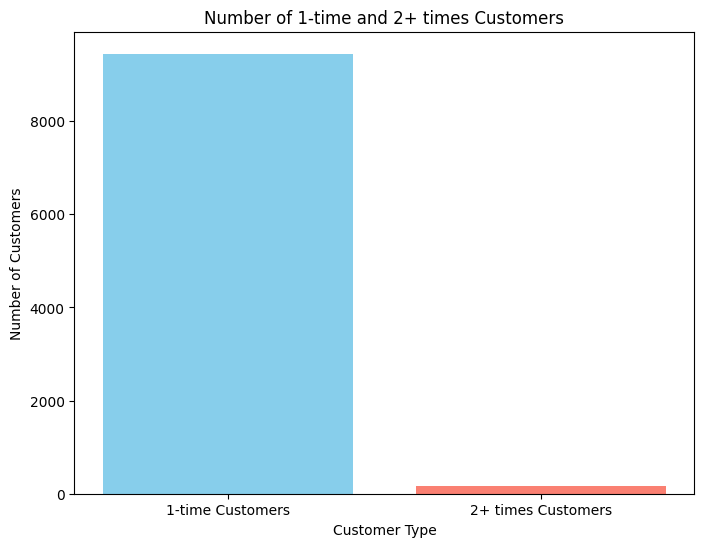

In [11]:
df = pd.read_csv("../data/for_simulation.csv")
for x in ['High', 'Mid', 'Low', 'Very Low']:
    # 고객별 주문 횟수 계산
    customer_order_counts = df[df['trust_level'] == x].groupby('customer_unique_id')['order_id'].nunique()

    # 1번 이용한 고객과 2번 이상 이용한 고객 분리
    one_time_customers = customer_order_counts[customer_order_counts == 1].index
    multi_time_customers = customer_order_counts[customer_order_counts > 1].index

    # 1번 이용한 고객 수와 다수 이용한 고객 수
    one_time_customer_count = len(one_time_customers)
    multi_time_customer_count = len(multi_time_customers)
    print(x)
    print(one_time_customer_count, multi_time_customer_count)
    # 그래프 그리기
    plt.figure(figsize=(8, 6))
    plt.bar(['1-time Customers', '2+ times Customers'], [one_time_customer_count, multi_time_customer_count], color=['skyblue', 'salmon'])
    plt.xlabel('Customer Type')
    plt.ylabel('Number of Customers')
    plt.title('Number of 1-time and 2+ times Customers')
    plt.show()
